<a href="https://colab.research.google.com/github/yujeeb/pytorch-explorer/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options).

## 1. Make classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


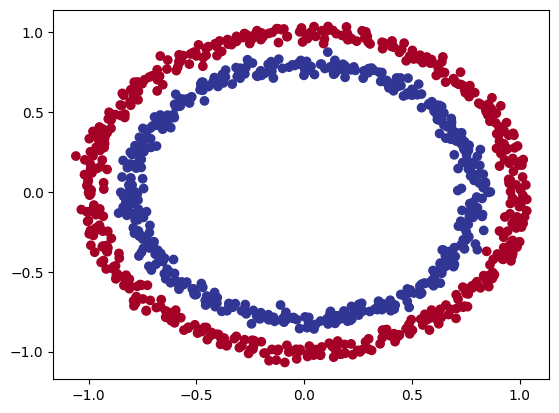

In [ ]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of y: {y_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of y: () and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.1.0+cu121'

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layer capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2404, -0.1211],
                      [-0.1175,  0.0473],
                      [-0.4350,  0.5565],
                      [ 0.5149, -0.0340],
                      [-0.4335, -0.0922]])),
             ('0.bias', tensor([ 0.4840,  0.6640, -0.5256,  0.3489, -0.0645])),
             ('1.weight',
              tensor([[-0.3195,  0.2331,  0.0173, -0.0171,  0.0820]])),
             ('1.bias', tensor([0.0624]))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squard error).

For classification you miight want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`

In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to inpuut to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).in

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1364],
        [ 0.0900],
        [ 0.1353],
        [ 0.1373],
        [-0.0597]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5341],
        [0.5225],
        [0.5338],
        [0.5343],
        [0.4851]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for quality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train , y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss() expects prediction probabilities as input
                 y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69485, Acc: 49.62% | Test loss: 0.69413, Test acc: 56.00%
Epoch: 10 | Loss: 0.69455, Acc: 49.88% | Test loss: 0.69394, Test acc: 56.00%
Epoch: 20 | Loss: 0.69431, Acc: 50.00% | Test loss: 0.69381, Test acc: 54.00%
Epoch: 30 | Loss: 0.69412, Acc: 49.88% | Test loss: 0.69371, Test acc: 51.50%
Epoch: 40 | Loss: 0.69396, Acc: 50.00% | Test loss: 0.69364, Test acc: 52.50%
Epoch: 50 | Loss: 0.69383, Acc: 49.75% | Test loss: 0.69359, Test acc: 54.00%
Epoch: 60 | Loss: 0.69372, Acc: 49.62% | Test loss: 0.69355, Test acc: 54.00%
Epoch: 70 | Loss: 0.69362, Acc: 49.62% | Test loss: 0.69353, Test acc: 54.50%
Epoch: 80 | Loss: 0.69354, Acc: 49.25% | Test loss: 0.69351, Test acc: 55.00%
Epoch: 90 | Loss: 0.69347, Acc: 49.25% | Test loss: 0.69350, Test acc: 56.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`

In [35]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


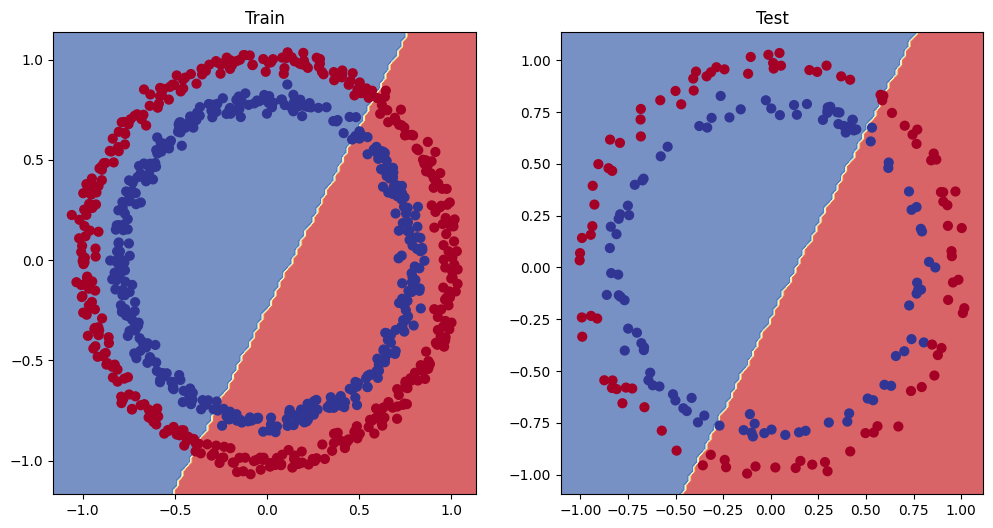

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


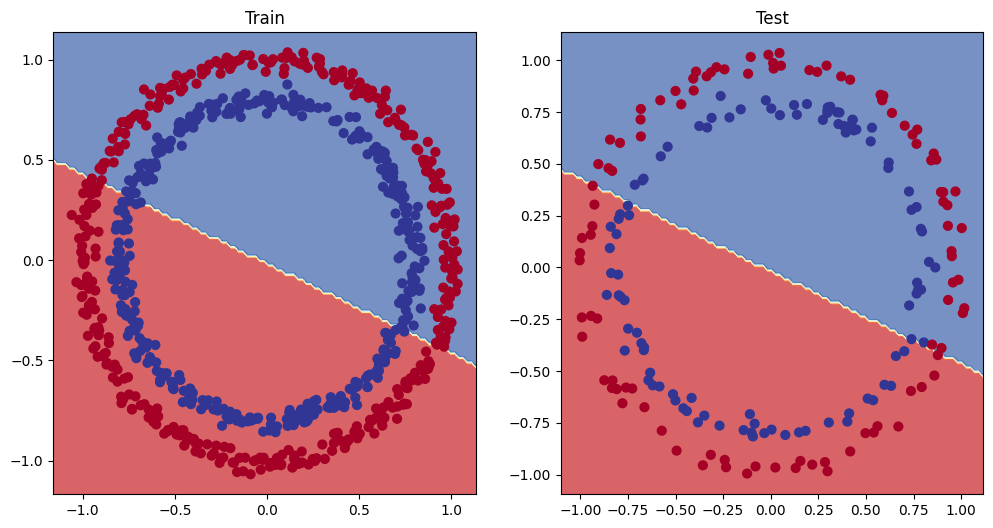

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


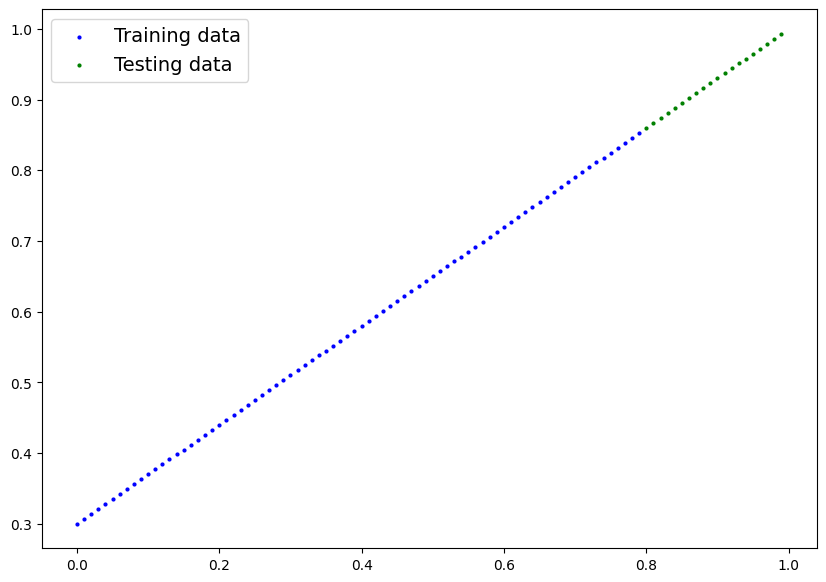

In [ ]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


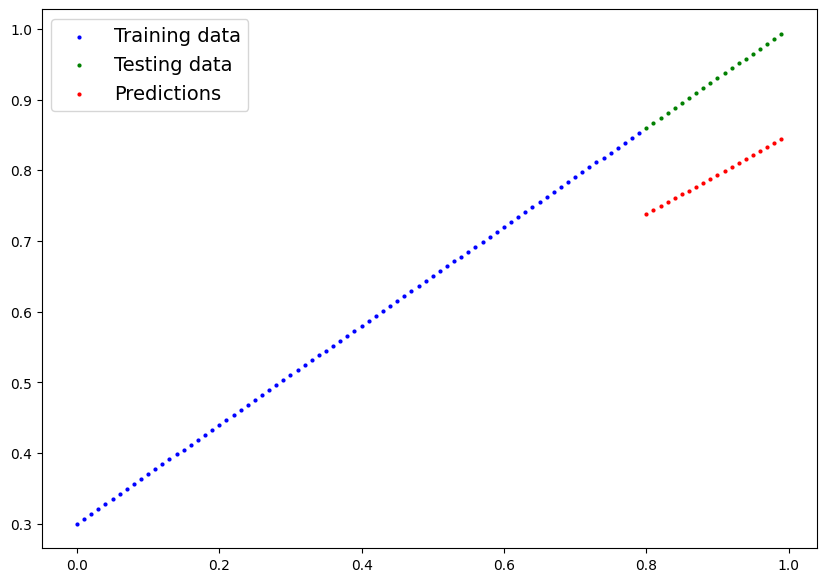

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

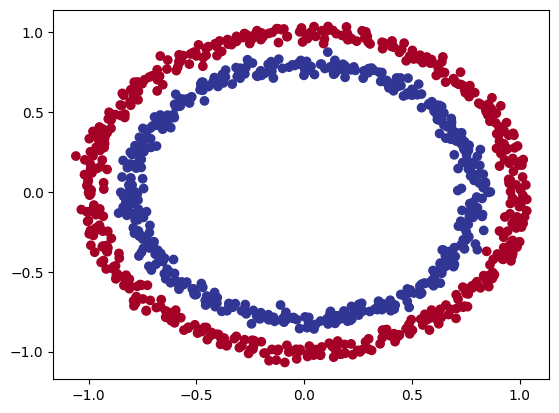

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test loss: 0.6215, Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

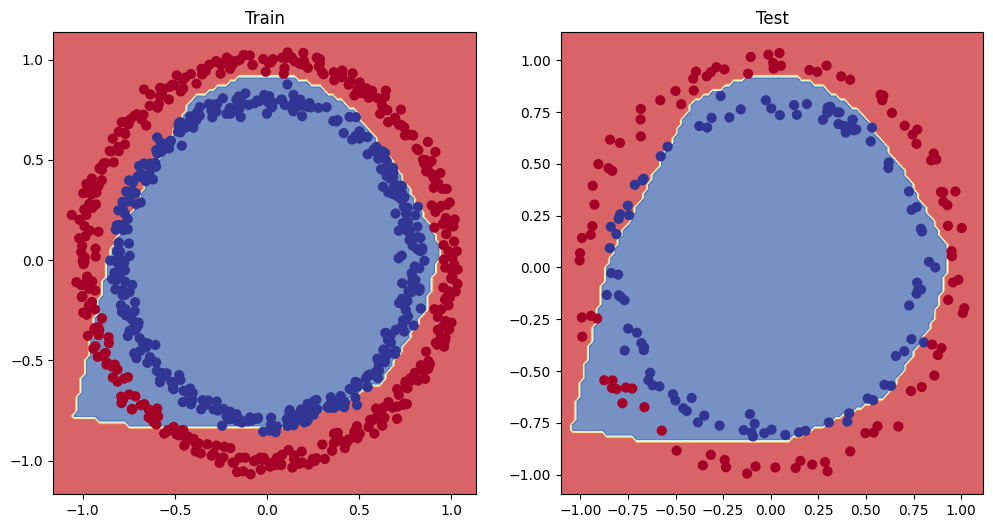

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

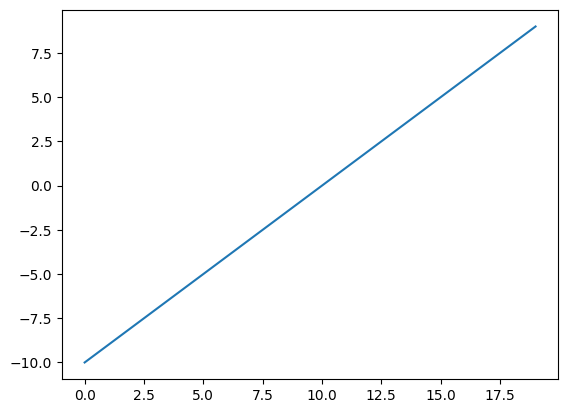

In [ ]:
# Visualize the tensor
plt.plot(A);

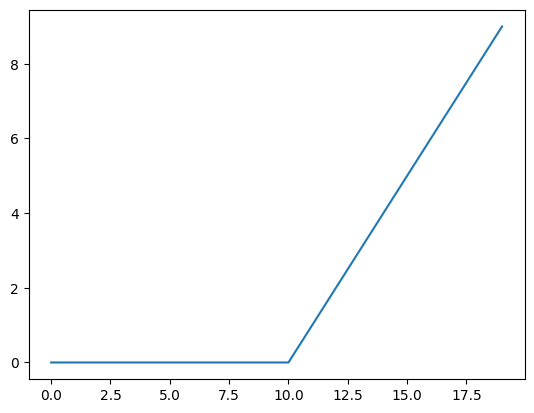

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

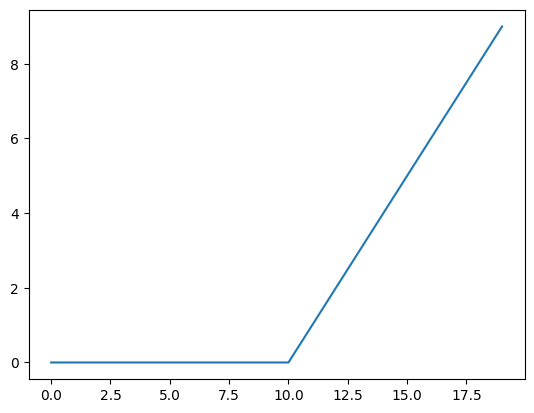

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

In [ ]:
# Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

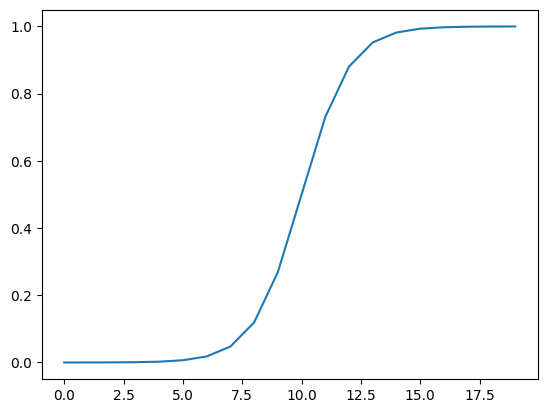

In [ ]:
plt.plot(torch.sigmoid(A))

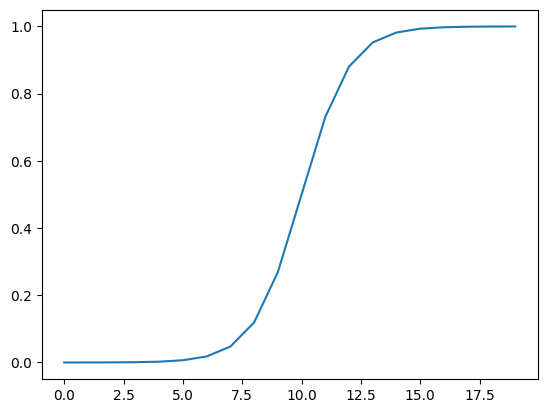

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

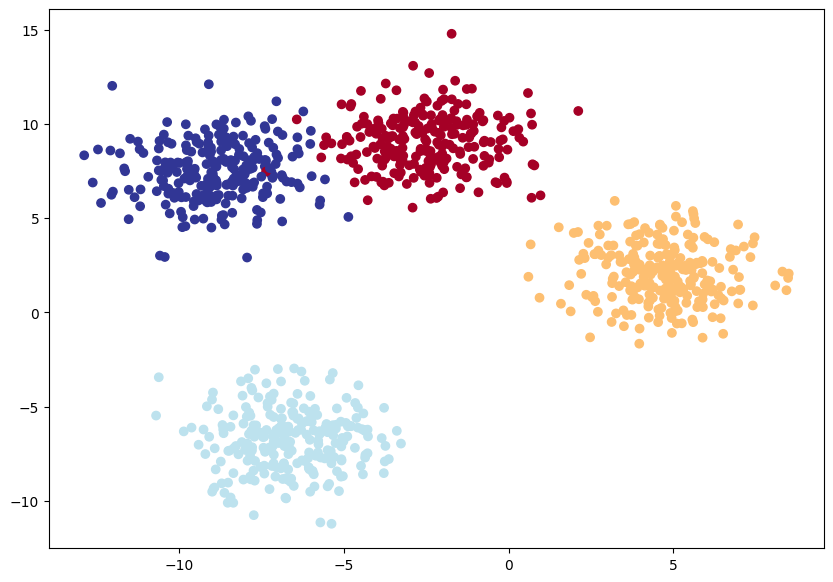

In [84]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [85]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [86]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [87]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [88]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.0104, -0.3555, -0.0934,  0.0580],
        [ 0.4913, -0.5232,  0.4720,  0.3557],
        [ 0.5571, -0.0292,  0.6435,  0.1088],
        [-0.0616, -0.2506, -0.1222, -0.1242],
        [ 0.1356, -0.6591,  0.0185,  0.1062],
        [ 0.5350, -0.4723,  0.5258,  0.3770],
        [ 0.5354,  0.0306,  0.6591,  0.1537],
        [ 0.3052, -0.6231,  0.2456,  0.2559],
        [ 0.5836, -0.1719,  0.6011,  0.1887],
        [ 0.2345, -0.6299,  0.1615,  0.2073]])

In [89]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0104, -0.3555, -0.0934,  0.0580],
        [ 0.4913, -0.5232,  0.4720,  0.3557],
        [ 0.5571, -0.0292,  0.6435,  0.1088],
        [-0.0616, -0.2506, -0.1222, -0.1242],
        [ 0.1356, -0.6591,  0.0185,  0.1062]])
tensor([[0.2745, 0.1903, 0.2474, 0.2878],
        [0.3109, 0.1127, 0.3049, 0.2715],
        [0.3044, 0.1694, 0.3318, 0.1944],
        [0.2697, 0.2232, 0.2538, 0.2533],
        [0.3019, 0.1364, 0.2685, 0.2932]])


In [90]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
        2, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 3, 3,
        0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 3, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2,
        2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 2, 2, 0,
        2, 2, 2, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 2, 2, 3, 2, 2, 0, 3, 2, 2, 0, 0,
        0, 0, 2, 0, 0, 0, 2, 3])

In [91]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [92]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1200

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    # Print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.2907, Acc: 47.25% | Test loss: 1.2397, Test acc: 51.00%
Epoch: 10 | Loss: 0.9412, Acc: 75.50% | Test loss: 0.9191, Test acc: 71.00%
Epoch: 20 | Loss: 0.6899, Acc: 98.62% | Test loss: 0.6830, Test acc: 99.50%
Epoch: 30 | Loss: 0.5352, Acc: 99.12% | Test loss: 0.5365, Test acc: 99.50%
Epoch: 40 | Loss: 0.4365, Acc: 99.25% | Test loss: 0.4401, Test acc: 99.50%
Epoch: 50 | Loss: 0.3608, Acc: 99.12% | Test loss: 0.3634, Test acc: 99.50%
Epoch: 60 | Loss: 0.2974, Acc: 99.12% | Test loss: 0.2982, Test acc: 99.50%
Epoch: 70 | Loss: 0.2453, Acc: 99.12% | Test loss: 0.2446, Test acc: 99.50%
Epoch: 80 | Loss: 0.2042, Acc: 99.12% | Test loss: 0.2023, Test acc: 99.50%
Epoch: 90 | Loss: 0.1725, Acc: 99.12% | Test loss: 0.1696, Test acc: 99.50%
Epoch: 100 | Loss: 0.1480, Acc: 99.12% | Test loss: 0.1445, Test acc: 99.50%
Epoch: 110 | Loss: 0.1292, Acc: 99.00% | Test loss: 0.1250, Test acc: 99.50%
Epoch: 120 | Loss: 0.1144, Acc: 99.00% | Test loss: 0.1098, Test acc: 99.50%
Epoch: 130

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [93]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6649,  5.3507, -3.5137, -1.5796],
        [ 0.2371, -2.6797, -1.8268,  4.7884],
        [-1.7202, -2.2543,  5.8297, -0.7117],
        [-1.3129,  5.5774, -2.4899, -2.6004],
        [ 4.9843, -1.8545, -2.5583, -0.4387],
        [ 0.2182, -2.6881, -1.8233,  4.8130],
        [-2.1562, -1.8181,  5.6725, -0.6737],
        [ 5.0134, -2.0092, -2.5087, -0.3831],
        [-1.6064, -2.3366,  5.7795, -0.6556],
        [ 5.0099, -1.9596, -2.5209, -0.4114]])

In [94]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4318e-03, 9.9645e-01, 1.4083e-04, 9.7421e-04],
        [1.0424e-02, 5.6397e-04, 1.3234e-03, 9.8769e-01],
        [5.2494e-04, 3.0775e-04, 9.9773e-01, 1.4392e-03],
        [1.0160e-03, 9.9839e-01, 3.1312e-04, 2.8036e-04],
        [9.9402e-01, 1.0649e-03, 5.2681e-04, 4.3875e-03],
        [9.9850e-03, 5.4596e-04, 1.2964e-03, 9.8817e-01],
        [3.9706e-04, 5.5677e-04, 9.9730e-01, 1.7487e-03],
        [9.9407e-01, 8.8624e-04, 5.3781e-04, 4.5055e-03],
        [6.1841e-04, 2.9796e-04, 9.9748e-01, 1.6002e-03],
        [9.9414e-01, 9.3453e-04, 5.3315e-04, 4.3953e-03]])

In [95]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [96]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

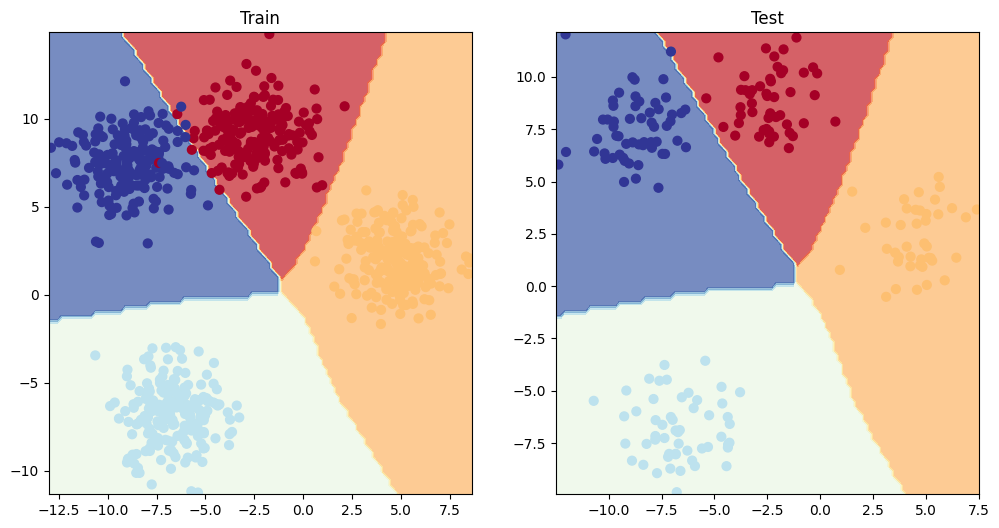

In [97]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [98]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.0 MB/s eta 0:00:00


In [101]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
accuracy = torchmetric_accuracy(y_preds, y_blob_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00
